# Introduction

## Domain-specific Area

With social media platforms on the rise, in terms of usage, it has transformed how information is and will be disseminated and consumed by someone. While social media has numerous benefits, it does pose significant challenges or disadvantages. With one of them being, the increasing spread of misinformation, also known as fake news, it's becoming a significant concern in today's digital age. This is why a Fake news detection algorithm is crucial in maintaining the integrity of information that is being disseminated through social media and other online platforms such as blogs. According to a Malaysian journal of Medicine and Health Sciences, social media and internet can also be the culprit in the spread of misinformation to the public.

Text classification methodologies includes both traditional statistical models and deep learning approaches, these play a crucial role in identifying and mitigating the spread of fake news. By categorizing the tweets into predefined labels, which in this case would be "real" and "fake", the models can assist in filtering out misinformation before it reaches to a wider audience. However, these predefined labels will need to be converted into binary figures, 1s and 0s, before being inserted into the models. This project will focus on developing and comparing text classification methods to achieve the ability to successfully distinguish between fake and real tweets. The project also aims to explore the effectiveness of different text classification methods in categorizing tweets according to real and fake and providing insights into their applicability and performance in real-world scenarios. 

## Objectives

The primary objectives of this project are too compare the performance of traditional statistical models and a modern deep learning model in text classification, specifically in identifying real and fake tweets. The comparison done in this project will highlight the strengths and weakness of each approach and it will allow us to determine their suitability for different types of text classification challenges. Here are the specific goals:

1. Evaluation of Model Performance
   - To be able to effectively assess the traditional statistical model and modern deep learning model in calssifying tweets as real or fake
2. Comparison of Approaches
   - Effectively identify the strengths and weaknesses of each approach through the comparison of their performance metrics and analyzing their applicability in real-world case scenarios
3. Improvement of Understanding
    - To gain a better understanding of text classification tasks
  
These objectives will aim to contribute to combating against misinformation by improving the tools available for automatic text classification and providing an understanding of trade-offs when using different models.

## Dataset Description


The "COVID19 Fake News Dataset NLP" dataset was taken from Kaggle where it is about COVID-19 Fake and Real Tweets where it has 6,420 unqiue entries in the training dataset, 2,140 unique entries in the validation dataset and another 2,140 unqiue entries in the testing dataset. These datasets was intially part of a task for a competition on hostile post detection.
These datasets mainly contains strings for the tweets content and categorization of tweets. The only integer type of the dataset would be the unique ID for each tweet.

## Evaluation Methodology

In this section, I will be discussing about the evaluation metrics used to measure the performance of the models.

- Accuracy: Ratio of correctly predicted instances to total instances
- Precision: Ratio of true positive predictions to total predicted positives
- Recall: Ratio of true positive predictions to total actual positives
- F1-Score: A combination mean of precision and recall, a single metric that has the balance of both

These metrics will both be utilized in the computation for the traditional statistical model, KNN, and the deep learning model, LSTM. The comparison will be based on the validation set results to determine which of the two models performs better in the identification and classification of fake and real tweets. 

The dataset has already been split into training, validation and testing sets to ensure a robust evaluation. Where the training set will be utilized to train the models and testing set will be used to evaluate the final performance.

By following this evaluation methodology, the project aims to provide a comprehensive analysis of the effectiveness of the traditional (KNN) and deep learning model (LSTM with Word2Vec) in text classification.

In [3]:
# Import of libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [4]:
# Loading of datasets
train_df = pd.read_csv('data_train.csv')
val_df = pd.read_csv('data_val.csv')
test_df = pd.read_csv('data_test.csv')

## Data Preprocessing

In [5]:
train_df.head()

,id,tweet,label
0,1,The CDC currently reports 99031 deaths. In gen...,real
1,2,States reported 1121 deaths a small rise from ...,real
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,5,Populous states can generate large case counts...,real


In [6]:
val_df.head()

,id,tweet,label
0,1,Chinese converting to Islam after realising th...,fake
1,2,11 out of 13 people (from the Diamond Princess...,fake
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake
3,4,Mike Pence in RNC speech praises Donald Trump’...,fake
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,real


In [7]:
test_df.head()

,id,tweet
0,1,Our daily update is published. States reported...
1,2,Alfalfa is the only cure for COVID-19.
2,3,President Trump Asked What He Would Do If He W...
3,4,States reported 630 deaths. We are still seein...
4,5,This is the sixth time a global health emergen...


### Checking for Null Values

In [8]:
print("Training Set:\n", train_df.isnull().any()) #Check for null values in the training set
print("Validation Set:\n", test_df.isnull().any()) #Check for null values in the validation set
print("Testing Set:\n", val_df.isnull().any()) #Check for null values in the testing set

Training Set:
 id       False
tweet    False
label    False
dtype: bool
Validation Set:
 id       False
tweet    False
dtype: bool
Testing Set:
 id       False
tweet    False
label    False
dtype: bool


### Exploration of data

In [9]:
print(train_df["tweet"][0]) #Print a simple tweet example
print(train_df["tweet"][300]) #Print a more typical tweet example

The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death toll stands at roughly 100000 people today.
NEW: There have been numerous #COVID19 outbreaks on recent cruise ship voyages. @CDCDirector has extended the previous No Sail Order to prevent the spread of COVID-19 among crew onboard. https://t.co/OTWJgCN8wQ https://t.co/sbHX4p907F


There seems to be tweets with hashtags and links in it, will require a more intensive and thorough cleaning of the tweets

In [10]:
print("Training Labels:\n", train_df["label"].value_counts()) #See the training labels
print("Validation Labels:\n", val_df["label"].value_counts()) #See the validation labels

Training Labels:
 label
real    3360
fake    3060
Name: count, dtype: int64
Validation Labels:
 label
real    1120
fake    1020
Name: count, dtype: int64


Seems like the categorization of tweets are in a string rather than 0s and 1s, will require dummies to convert the "real" and "fake" into 1s and 0s

### Processing of Tweets

In [11]:
import string
import re
import html
import nltk
from nltk.corpus import stopwords 

puncs = string.punctuation 
stop_words = stopwords.words("english")

In [12]:
def clean_tweets(ParseTweet):
    for i in range(0, len(ParseTweet)):
        # Puts tweet into a variable
        tweet = ParseTweet[i]
        # Removing leftover HTML elements
        tweet = html.unescape(tweet)
        # Removal of "@"s
        tweet = re.sub(r"@/w+", " ", tweet)
        # Removal of links
        tweet = re.sub(r"http\S+", " ", tweet)
        # Removal of puncs
        tweet = "".join([punc for punc in tweet if not punc in puncs])
        # Lowercase conversion
        tweet = tweet.lower()
        # Disect tweet into individual wordings
        tweet_Word = tweet.split()
        # Checking if the word is a stopword
        ParseTweet[i] = "".join([word + " " for word in tweet_Word if not word in stop_words])
    return ParseTweet

In [13]:
train_df["cleanedTweets"] = clean_tweets(train_df["tweet"].copy())
train_df.head()

,id,tweet,label,cleanedTweets
0,1,The CDC currently reports 99031 deaths. In gen...,real,cdc currently reports 99031 deaths general dis...
1,2,States reported 1121 deaths a small rise from ...,real,states reported 1121 deaths small rise last tu...
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake,politically correct woman almost uses pandemic...
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real,indiafightscorona 1524 covid testing laborator...
4,5,Populous states can generate large case counts...,real,populous states generate large case counts loo...


In [14]:
test_df["cleanedTweets"] = clean_tweets(test_df["tweet"].copy())
test_df.head()

,id,tweet,cleanedTweets
0,1,Our daily update is published. States reported...,daily update published states reported 734k te...
1,2,Alfalfa is the only cure for COVID-19.,alfalfa cure covid19
2,3,President Trump Asked What He Would Do If He W...,president trump asked would catch coronavirus ...
3,4,States reported 630 deaths. We are still seein...,states reported 630 deaths still seeing solid ...
4,5,This is the sixth time a global health emergen...,sixth time global health emergency declared in...


In [15]:
val_df["cleanedTweets"] = clean_tweets(val_df["tweet"].copy())
val_df.head()

,id,tweet,label,cleanedTweets
0,1,Chinese converting to Islam after realising th...,fake,chinese converting islam realising muslim affe...
1,2,11 out of 13 people (from the Diamond Princess...,fake,11 13 people diamond princess cruise ship inti...
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake,covid19 caused bacterium virus treated aspirin
3,4,Mike Pence in RNC speech praises Donald Trump’...,fake,mike pence rnc speech praises donald trump’s c...
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,real,610 skys edconwaysky explains latest covid19 d...


### Label Encoding

In [16]:
# Using pd.get_dummies and astype(int) to convert boolean values to integers
train_dummy = pd.get_dummies(train_df["label"], drop_first=True).astype(int)
print(train_dummy)

      real
0        1
1        1
2        0
3        1
4        1
...    ...
6415     0
6416     0
6417     0
6418     0
6419     1

[6420 rows x 1 columns]


In [17]:
train_df["LabelEncoded"] = train_dummy["real"]
train_df.head()

,id,tweet,label,cleanedTweets,LabelEncoded
0,1,The CDC currently reports 99031 deaths. In gen...,real,cdc currently reports 99031 deaths general dis...,1
1,2,States reported 1121 deaths a small rise from ...,real,states reported 1121 deaths small rise last tu...,1
2,3,Politically Correct Woman (Almost) Uses Pandem...,fake,politically correct woman almost uses pandemic...,0
3,4,#IndiaFightsCorona: We have 1524 #COVID testin...,real,indiafightscorona 1524 covid testing laborator...,1
4,5,Populous states can generate large case counts...,real,populous states generate large case counts loo...,1


In [18]:
val_df["LabelEncoded"] = pd.get_dummies(val_df["label"], drop_first=True).astype(int)
val_df.head()

,id,tweet,label,cleanedTweets,LabelEncoded
0,1,Chinese converting to Islam after realising th...,fake,chinese converting islam realising muslim affe...,0
1,2,11 out of 13 people (from the Diamond Princess...,fake,11 13 people diamond princess cruise ship inti...,0
2,3,"COVID-19 Is Caused By A Bacterium, Not Virus A...",fake,covid19 caused bacterium virus treated aspirin,0
3,4,Mike Pence in RNC speech praises Donald Trump’...,fake,mike pence rnc speech praises donald trump’s c...,0
4,5,6/10 Sky's @EdConwaySky explains the latest #C...,real,610 skys edconwaysky explains latest covid19 d...,1


### Tokenizing

In [19]:
import gensim
from gensim.models import Word2Vec

# Tokenize text data
tokenized_train = [tweet.split() for tweet in train_df['cleanedTweets']]
tokenized_val = [tweet.split() for tweet in val_df['cleanedTweets']]
tokenized_test = [tweet.split() for tweet in test_df['cleanedTweets']]

# Combine all data for training Word2Vec
tokenized_all = tokenized_train + tokenized_val + tokenized_test

# Train Word2Vec model
word2vec_model = Word2Vec(sentences=tokenized_all, vector_size=120, window=5, min_count=1, workers=4)
word2vec_model.save("word2vec_model.bin")

In [20]:
# Load Word2Vec model
word2vec_model = Word2Vec.load("word2vec_model.bin")

# Prepare embedding matrix
embedding_dim = 120
word_index = {word: index for index, word in enumerate(word2vec_model.wv.index_to_key, start=1)}
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

In [21]:
def text_to_sequence(text, word_index):
    return [word_index.get(word, 0) for word in text.split()]

X_train_seq = [text_to_sequence(tweet, word_index) for tweet in train_df['cleanedTweets']]
X_val_seq = [text_to_sequence(tweet, word_index) for tweet in val_df['cleanedTweets']]
X_test_seq = [text_to_sequence(tweet, word_index) for tweet in test_df['cleanedTweets']]

## Baseline Performance (KNN)

In [22]:
# TF-ID Vectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=20000, stop_words='english')

train_df_clean = train_df["cleanedTweets"].copy()
test_df_clean = test_df["cleanedTweets"].copy()
val_df_clean = val_df["cleanedTweets"].copy()

train_val_clean = pd.concat([train_df_clean, val_df_clean], ignore_index=True)

# Fit and transform the training and validation data
X_train_val = vectorizer.fit_transform(train_val_clean)

# Transform the test data
X_test = vectorizer.transform(test_df_clean)

# Split the combined data back into training and validation sets
X_train = X_train_val[:len(train_df)]
X_val = X_train_val[len(train_df):]

# Use the 'LabelEncoded' column for labels
y_train = train_df['LabelEncoded']
y_val = val_df['LabelEncoded']

In [23]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialize and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=5) 
knn.fit(X_train, y_train)

# Make predictions on the validation set
y_val_pred = knn.predict(X_val)

# Evaluate the KNN model
accuracy = accuracy_score(y_val, y_val_pred)
precision = precision_score(y_val, y_val_pred)
recall = recall_score(y_val, y_val_pred)
f1 = f1_score(y_val, y_val_pred)

print(f"Validation Accuracy: {accuracy}")
print(f"Validation Precision: {precision}")
print(f"Validation Recall: {recall}")
print(f"Validation F1-Score: {f1}")

Validation Accuracy: 0.9004672897196262
Validation Precision: 0.9096657633242999
Validation Recall: 0.8991071428571429
Validation F1-Score: 0.9043556353839246


In [24]:
# Predict on the test set
y_pred_test = knn.predict(X_test)

# Output predictions for the test set
test_df['PredictedLabel'] = y_pred_test
test_df.head()

,id,tweet,cleanedTweets,PredictedLabel
0,1,Our daily update is published. States reported...,daily update published states reported 734k te...,1
1,2,Alfalfa is the only cure for COVID-19.,alfalfa cure covid19,0
2,3,President Trump Asked What He Would Do If He W...,president trump asked would catch coronavirus ...,0
3,4,States reported 630 deaths. We are still seein...,states reported 630 deaths still seeing solid ...,1
4,5,This is the sixth time a global health emergen...,sixth time global health emergency declared in...,1


## Deep Learning Model (LTSM)

In [25]:
# Pad sequences
max_sequence_length = 120
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_val_pad = pad_sequences(X_val_seq, maxlen=max_sequence_length)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length)

y_train_pad = train_df['LabelEncoded']
y_val_pad = val_df['LabelEncoded']

# Build LSTM model
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=len(word_index) + 1,
                         output_dim=word2vec_model.vector_size,
                         weights=[embedding_matrix],
                         input_length=max_sequence_length,
                         trainable=False))
model_lstm.add(LSTM(128, return_sequences=True))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(64))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train LSTM model
history = model_lstm.fit(X_train_pad, y_train_pad, epochs=5, batch_size=32, validation_data=(X_val_pad, y_val_pad))

# Evaluate on test data
test_predictions = model_lstm.predict(X_test_pad)

Epoch 1/5


2024-07-08 13:25:00.522741: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-08 13:25:00.524054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-08 13:25:00.524542: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

201/201 [==============================] - ETA: 0s - loss: 0.4636 - accuracy: 0.7749

2024-07-08 13:25:24.016325: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-08 13:25:24.016868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-08 13:25:24.017337: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

201/201 [==============================] - 26s 122ms/step - loss: 0.4636 - accuracy: 0.7749 - val_loss: 0.4148 - val_accuracy: 0.8136
Epoch 2/5
201/201 [==============================] - 24s 118ms/step - loss: 0.4096 - accuracy: 0.8178 - val_loss: 0.4158 - val_accuracy: 0.8014
Epoch 3/5
201/201 [==============================] - 24s 117ms/step - loss: 0.4009 - accuracy: 0.8206 - val_loss: 0.4074 - val_accuracy: 0.8164
Epoch 4/5
201/201 [==============================] - 24s 119ms/step - loss: 0.3724 - accuracy: 0.8346 - val_loss: 0.3816 - val_accuracy: 0.8201
Epoch 5/5
201/201 [==============================] - 24s 119ms/step - loss: 0.3553 - accuracy: 0.8419 - val_loss: 0.3486 - val_accuracy: 0.8379


2024-07-08 13:27:01.793891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-08 13:27:01.794569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-08 13:27:01.795166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

67/67 [==============================] - 3s 34ms/step


In [26]:
# Predict and evaluate
y_pred_val_lstm = (model_lstm.predict(X_val_pad) > 0.5).astype("int32")
accuracy_val_lstm = accuracy_score(y_val_pad, y_pred_val_lstm)
precision_val_lstm = precision_score(y_val_pad, y_pred_val_lstm)
recall_val_lstm = recall_score(y_val_pad, y_pred_val_lstm)
f1_val_lstm = f1_score(y_val_pad, y_pred_val_lstm)

print(f'LSTM Validation - Accuracy: {accuracy_val_lstm}, Precision: {precision_val_lstm}, Recall: {recall_val_lstm}, F1-Score: {f1_val_lstm}')

67/67 [==============================] - 2s 34ms/step
LSTM Validation - Accuracy: 0.8378504672897197, Precision: 0.8756073858114675, Recall: 0.8044642857142857, F1-Score: 0.8385295486272686


## Comparison of both Models

As seen from above, there's a total of 2 models, KNN and LSTM with Word2Vec embeddings.

In terms of the KNN Model, there was utilization of the TF-IDF vectorization to conver the cleaned text data into numerical features. Through the use of the TF-IDF vectorizer, it captures the importance of each word in the document whilst taking into account the frequency. The KNN model was then intialize and trained with 5 neighbors and evaluated the model on the validation set.

Whilst the LSTM with Word2Vec embeddings has an input of sequences of word indices and the embedding layer will be initialized with pre-trained Word2Vec embeddings. The LSTM layer will processes those sequences of word embeddings and outputs binary classification. During the training process, the algorithm will convert text data into sequences of word indices and pads those sequences to ensure uniform length and the LSTM model will then train on those padded sequences.

In [27]:
# KNN model results
knn_results = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'K-Nearest Neighbors (KNN)': [
        f'{accuracy:.4f} (Accuracy)', 
        f'{precision:.4f} (Precision)', 
        f'{recall:.4f} (Recall)', 
        f'{f1:.4f} (F1-Score)'
    ]
}

# LSTM model results
lstm_results = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Long Short-Term Memory (LSTM)': [
        f'{accuracy_val_lstm:.4f} (Accuracy)', 
        f'{precision_val_lstm:.4f} (Precision)', 
        f'{recall_val_lstm:.4f} (Recall)', 
        f'{f1_val_lstm:.4f} (F1-Score)'
    ]
}

# Convert the results to DataFrames
knn_df = pd.DataFrame(knn_results)
lstm_df = pd.DataFrame(lstm_results)

# Merge the DataFrames on the 'Metric' column
comparison_df = pd.merge(knn_df, lstm_df, on='Metric')

# Display the comparison table
print(comparison_df)

      Metric K-Nearest Neighbors (KNN) Long Short-Term Memory (LSTM)
0   Accuracy         0.9005 (Accuracy)             0.8379 (Accuracy)
1  Precision        0.9097 (Precision)            0.8756 (Precision)
2     Recall           0.8991 (Recall)               0.8045 (Recall)
3   F1-Score         0.9044 (F1-Score)             0.8385 (F1-Score)


As seen from the comparison table above, the KNN model achieved a higher validation accuracy compared to the LSTM model. Which indicates that for this particular dataset, the traditional KNN classfier performed slightly better than the LSTM model. 
The KNN model also had a higher recall compared to the LSTM model which translates to the fact that the KNN model was better at correctly identifying fake tweets. The KNN also achieved a slightly higher precision score as compared to the LSTM model which tells us that the KNN model is slightly better at predicting the outcome of a fake tweet.

This surprising outcome could be due to several factors such as:
1. Data Characteristics
   - The TF-IDF features may be more suitable for a distance-based classifier like KNN.
2. Complexity of the Model
   - Since the LSTM model is more complex, it probably might need more data or fine-tuning to outperform the KNN model.
3. Validation, Training and Testing Split of Data
   - The split of the data into training, validation and testing sets can affect the model performance.
  
Hence, I will be performing some improvements on the LSTM model in the next step.

In [28]:
# Improved LSTM model
Imp_model_lstm = Sequential()
Imp_model_lstm.add(Embedding(input_dim=len(word_index) + 1,
                         output_dim=word2vec_model.vector_size,
                         weights=[embedding_matrix],
                         input_length=max_sequence_length,
                         trainable=True))  # Set trainable=True to fine-tune embeddings
Imp_model_lstm.add(Bidirectional(LSTM(128, return_sequences=True)))
Imp_model_lstm.add(Dropout(0.5))
Imp_model_lstm.add(LSTM(64))
Imp_model_lstm.add(Dense(1, activation='sigmoid'))

Imp_model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

# Train LSTM model
imp_history = Imp_model_lstm.fit(X_train_pad, y_train_pad, epochs=10, batch_size=32, validation_data=(X_val_pad, y_val_pad),
               callbacks=[early_stopping, reduce_lr])

# Evaluate on test data
test_predictions = Imp_model_lstm.predict(X_test_pad)


Epoch 1/10


2024-07-08 13:27:06.720090: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-08 13:27:06.720562: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-08 13:27:06.721077: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

201/201 [==============================] - ETA: 0s - loss: 0.3891 - accuracy: 0.8218

2024-07-08 13:27:40.489813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-08 13:27:40.490418: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-08 13:27:40.491238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

201/201 [==============================] - 37s 176ms/step - loss: 0.3891 - accuracy: 0.8218 - val_loss: 0.2854 - val_accuracy: 0.8930 - lr: 0.0010
Epoch 2/10
201/201 [==============================] - 34s 168ms/step - loss: 0.1249 - accuracy: 0.9548 - val_loss: 0.1779 - val_accuracy: 0.9276 - lr: 0.0010
Epoch 3/10
201/201 [==============================] - 37s 186ms/step - loss: 0.0298 - accuracy: 0.9894 - val_loss: 0.3828 - val_accuracy: 0.8804 - lr: 0.0010
Epoch 4/10
201/201 [==============================] - 37s 186ms/step - loss: 0.0114 - accuracy: 0.9964 - val_loss: 0.2241 - val_accuracy: 0.9215 - lr: 0.0010
Epoch 5/10
201/201 [==============================] - 36s 181ms/step - loss: 0.0030 - accuracy: 0.9991 - val_loss: 0.2549 - val_accuracy: 0.9238 - lr: 2.0000e-04


2024-07-08 13:30:09.051287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-07-08 13:30:09.052169: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-07-08 13:30:09.052817: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

67/67 [==============================] - 3s 43ms/step


In [29]:
# Predict and evaluate
y_pred_val_Imp_lstm = (Imp_model_lstm.predict(X_val_pad) > 0.5).astype("int32")
accuracy_val_Imp_lstm = accuracy_score(y_val_pad, y_pred_val_Imp_lstm)
precision_val_Imp_lstm = precision_score(y_val_pad, y_pred_val_Imp_lstm)
recall_val_Imp_lstm = recall_score(y_val_pad, y_pred_val_Imp_lstm)
f1_val_Imp_lstm = f1_score(y_val_pad, y_pred_val_Imp_lstm)

print(f'LSTM Validation - Accuracy: {accuracy_val_Imp_lstm}, Precision: {precision_val_Imp_lstm}, Recall: {recall_val_Imp_lstm}, F1-Score: {f1_val_Imp_lstm}')

67/67 [==============================] - 3s 48ms/step
LSTM Validation - Accuracy: 0.927570093457944, Precision: 0.9148753224419605, Recall: 0.95, F1-Score: 0.9321068769163382


In [30]:
# Improved LSTM model results
imp_lstm_results = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Improved Long Short-Term Memory (LSTM)': [
        f'{accuracy_val_Imp_lstm:.4f} (Accuracy)', 
        f'{precision_val_Imp_lstm:.4f} (Precision)', 
        f'{recall_val_Imp_lstm:.4f} (Recall)', 
        f'{f1_val_Imp_lstm:.4f} (F1-Score)'
    ]
}

imp_lstm_df = pd.DataFrame(imp_lstm_results)
new_comparison_df = pd.merge(comparison_df, imp_lstm_df, on='Metric')

# Display the comparison table
print(new_comparison_df)

      Metric K-Nearest Neighbors (KNN) Long Short-Term Memory (LSTM)  \
0   Accuracy         0.9005 (Accuracy)             0.8379 (Accuracy)   
1  Precision        0.9097 (Precision)            0.8756 (Precision)   
2     Recall           0.8991 (Recall)               0.8045 (Recall)   
3   F1-Score         0.9044 (F1-Score)             0.8385 (F1-Score)   

  Improved Long Short-Term Memory (LSTM)  
0                      0.9276 (Accuracy)  
1                     0.9149 (Precision)  
2                        0.9500 (Recall)  
3                      0.9321 (F1-Score)  


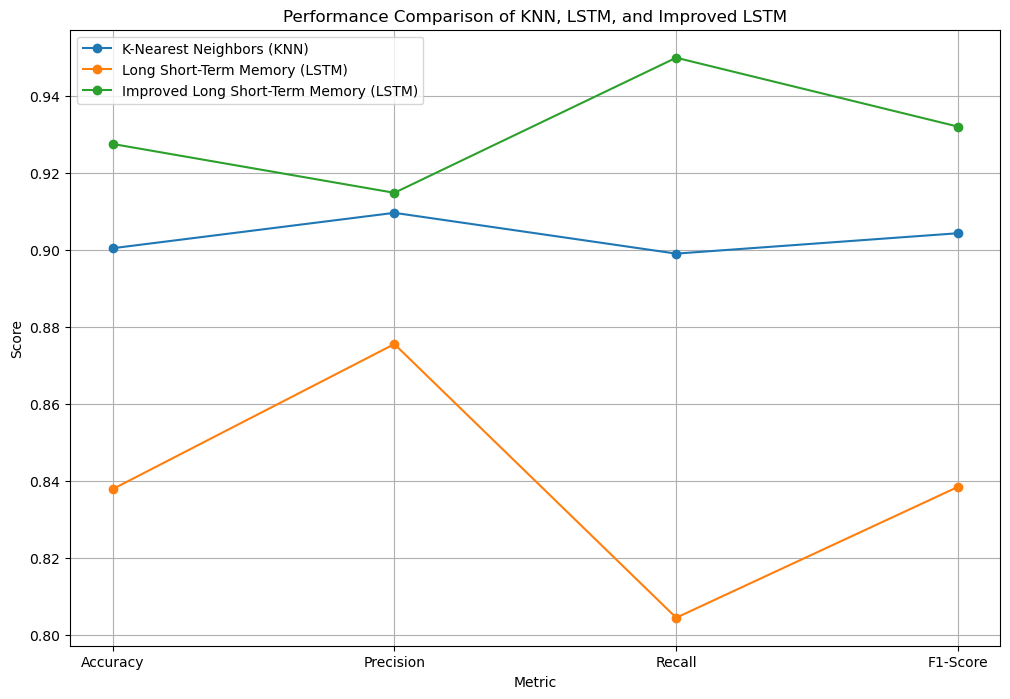

In [32]:
import matplotlib.pyplot as plt
knn_df = pd.DataFrame(knn_results)
lstm_df = pd.DataFrame(lstm_results)
imp_lstm_df = pd.DataFrame(imp_lstm_results)

comparison_df = pd.merge(knn_df, lstm_df, on='Metric')
comparison_df = pd.merge(comparison_df, imp_lstm_df, on='Metric')

# Extract numerical values for plotting
comparison_df['K-Nearest Neighbors (KNN)'] = comparison_df['K-Nearest Neighbors (KNN)'].str.extract(r'([0-9.]+)').astype(float)
comparison_df['Long Short-Term Memory (LSTM)'] = comparison_df['Long Short-Term Memory (LSTM)'].str.extract(r'([0-9.]+)').astype(float)
comparison_df['Improved Long Short-Term Memory (LSTM)'] = comparison_df['Improved Long Short-Term Memory (LSTM)'].str.extract(r'([0-9.]+)').astype(float)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

# Plot each model's metrics
ax.plot(comparison_df['Metric'], comparison_df['K-Nearest Neighbors (KNN)'], marker='o', label='K-Nearest Neighbors (KNN)')
ax.plot(comparison_df['Metric'], comparison_df['Long Short-Term Memory (LSTM)'], marker='o', label='Long Short-Term Memory (LSTM)')
ax.plot(comparison_df['Metric'], comparison_df['Improved Long Short-Term Memory (LSTM)'], marker='o', label='Improved Long Short-Term Memory (LSTM)')

# Adding labels and title
ax.set_xlabel('Metric')
ax.set_ylabel('Score')
ax.set_title('Performance Comparison of KNN, LSTM, and Improved LSTM')
ax.legend()

# Display the plot
plt.grid(True)
plt.show()

As you can see from the graph above, the improved LSTM outperformed the KNN and the original LSTM models in every metric.

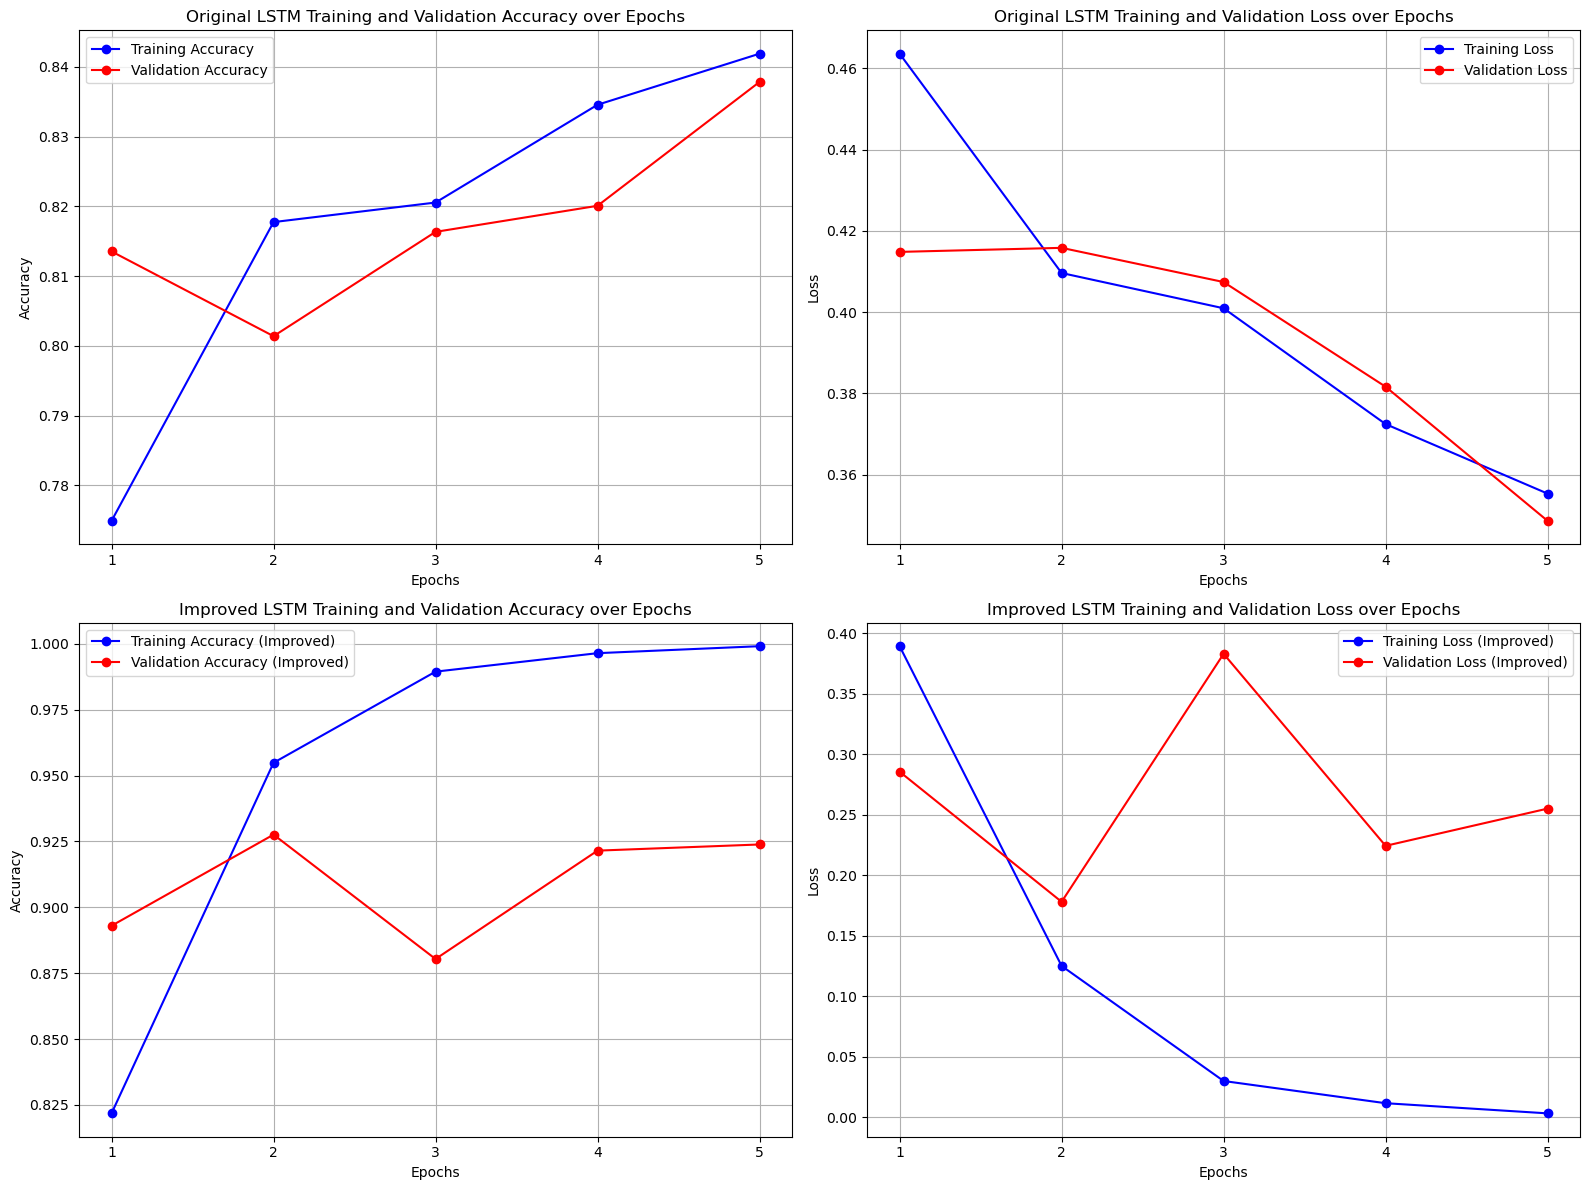

In [33]:
# Retrieve metrics from original LSTM model
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Retrieve metrics from improved LSTM model
imp_train_accuracy = imp_history.history['accuracy']
imp_val_accuracy = imp_history.history['val_accuracy']
imp_train_loss = imp_history.history['loss']
imp_val_loss = imp_history.history['val_loss']

# Plotting accuracy and loss side by side
fig, axs = plt.subplots(2, 2, figsize=(16, 12))

# Plot Training and Validation Accuracy
axs[0, 0].plot(range(1, len(train_accuracy) + 1), train_accuracy, marker='o', linestyle='-', color='b', label='Training Accuracy')
axs[0, 0].plot(range(1, len(val_accuracy) + 1), val_accuracy, marker='o', linestyle='-', color='r', label='Validation Accuracy')
axs[0, 0].set_title('Original LSTM Training and Validation Accuracy over Epochs')
axs[0, 0].set_xlabel('Epochs')
axs[0, 0].set_ylabel('Accuracy')
axs[0, 0].set_xticks(range(1, len(train_accuracy) + 1))
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot Training and Validation Loss
axs[0, 1].plot(range(1, len(train_loss) + 1), train_loss, marker='o', linestyle='-', color='b', label='Training Loss')
axs[0, 1].plot(range(1, len(val_loss) + 1), val_loss, marker='o', linestyle='-', color='r', label='Validation Loss')
axs[0, 1].set_title('Original LSTM Training and Validation Loss over Epochs')
axs[0, 1].set_xlabel('Epochs')
axs[0, 1].set_ylabel('Loss')
axs[0, 1].set_xticks(range(1, len(train_loss) + 1))
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot Training and Validation Accuracy (Improved LSTM)
axs[1, 0].plot(range(1, len(imp_train_accuracy) + 1), imp_train_accuracy, marker='o', linestyle='-', color='b', label='Training Accuracy (Improved)')
axs[1, 0].plot(range(1, len(imp_val_accuracy) + 1), imp_val_accuracy, marker='o', linestyle='-', color='r', label='Validation Accuracy (Improved)')
axs[1, 0].set_title('Improved LSTM Training and Validation Accuracy over Epochs')
axs[1, 0].set_xlabel('Epochs')
axs[1, 0].set_ylabel('Accuracy')
axs[1, 0].set_xticks(range(1, len(imp_train_accuracy) + 1))
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot Training and Validation Loss (Improved LSTM)
axs[1, 1].plot(range(1, len(imp_train_loss) + 1), imp_train_loss, marker='o', linestyle='-', color='b', label='Training Loss (Improved)')
axs[1, 1].plot(range(1, len(imp_val_loss) + 1), imp_val_loss, marker='o', linestyle='-', color='r', label='Validation Loss (Improved)')
axs[1, 1].set_title('Improved LSTM Training and Validation Loss over Epochs')
axs[1, 1].set_xlabel('Epochs')
axs[1, 1].set_ylabel('Loss')
axs[1, 1].set_xticks(range(1, len(imp_train_loss) + 1))
axs[1, 1].legend()
axs[1, 1].grid(True)

plt.tight_layout()
plt.show()


Accuracy
- In the original LSTM model, it increased over the number of epochs as the model is learning from the training data.
- In the improved LSTM model, it also displayed a similar pattern to the original LSTM model, whereby it increased over the number of epochs but it showed a more consistent upward trent and stablized at a higher accuracy as compared to the original LSTM model.

Validation Loss
- In the original LSTM model, the loss decreased over the number of epochs as the model is minimizing the error in predictions
- In the improved LSTM mode, it displayed a similar pattern to the original LSTM model, whereby it decreased over the number of epochs but it is a more consistent decline and it stablized at a lower value compared to the original model.

## Performance Analysis & Comparative Discussion

The table below shows the comparison of the performance metrics for the KNN, LSTM and Improved LSTM models

In [34]:
# Display the comparison table
print(new_comparison_df)

      Metric K-Nearest Neighbors (KNN) Long Short-Term Memory (LSTM)  \
0   Accuracy         0.9005 (Accuracy)             0.8379 (Accuracy)   
1  Precision        0.9097 (Precision)            0.8756 (Precision)   
2     Recall           0.8991 (Recall)               0.8045 (Recall)   
3   F1-Score         0.9044 (F1-Score)             0.8385 (F1-Score)   

  Improved Long Short-Term Memory (LSTM)  
0                      0.9276 (Accuracy)  
1                     0.9149 (Precision)  
2                        0.9500 (Recall)  
3                      0.9321 (F1-Score)  


The KNN model achieved a higher validation accuracy compared to the initial LSTM model which indicates that for this particular dataset, the traditional KNN model performed slightly better than the initial LSTM model.

The KNN model also had a higher recall which translates to the fact that it was better at correctly identifying fake tweets. However, the LSTM model achieved a slightly higher precision score which suggests that it was better at predicting the outcome of a fake tweet correctly.

The Improved LSTM model outperformed both the KNN and LSTM in all metrics which suggests that with the appropriate tuning and adjustments, a deep learning model like LSTM can perform better than traditional models.

### Advantages and Disadvantages

KNN:
- Advantages: Simple implementation, effective on small dataset, no training required
- Disadvantages: Sensitive to noisy and missing data, requires feature scaling, ineffective on large datasets

LSTM:
- Advantages: Ability to handle long sequences, avoids vanishing gradient problem, able to handle variable-length sequences, effective on large datasets
- Disadvantages: Computational complexity, overfitting, limited interpretability, long training times

### Hypothesized Reasons for Performance Disparities

This surprising outcome could be due to several factors such as:
1. Data Characteristics
   - The TF-IDF features may be more suitable for a distance-based classifier like KNN.
2. Complexity of the Model
   - Since the LSTM model is more complex, it probably might need more data or fine-tuning to outperform the KNN model.
3. Validation, Training and Testing Split of Data
   - The split of the data into training, validation and testing sets can affect the model performance.

## Project Summary and Reflections

### Learning Experience

This project has provided valuable insights pertaining to the effectiveness of traditional statistical models and modern deep learning models for text classification as I've always had the impression that a modern deep learning model would definetly out perform a traditional statistical model. But through this project, I've learnt that the KNN is more practical for smaller datasets and the LSTM will be more effective on larger datasets and complex sequential data but it will require more computational power and fine tuning.

### Potential Applications in the Real World

The KNN model would be suitable for simple and quick text classification tasks such as spam detection or basic sentiment analysis. Whereas, the LSTM model would be more suited for more complex tasks such as contextual understanding in chatbots, predictive text generation or detailed sentiment analysi or when there's a large dataset.

### Contribution to the Problem Area

With the improved LSTM model, it demonstrates the potential for more accurate classification of tweets in terms of them being real or fake which can contribute significantly to the fake news detection on social media platforms and in turn providing a more reliable tool for identifying misinformation as compared to other methods.

### Transferability to Other Domain-Specific Areas

The methodologies and insights that I've gained from this project can be transferred to other domains that involve text classification, such as email filtering and health information categorization. Take health information categorization as an example, where health information will be filtered according to their disease type based on certain words, that can be customized using a list.

### Improvements and Future Directions

In terms of improvements, a larger dataset would be better for the LSTM model or one could utilize data augmentation techniques to increase the diversity and size of the dataset. Another improvement would be to try and experiment with a hybrid model where it would be a combination of a traditional and deep learning model to utilize the strengths of both. The last improvement would be to develop a system where it would be able to become a real-time fake news detection and analysis as that would be more practical for more users which translates to reaching out to a larger user base.

## References

Aghammadzada, E. (2021) COVID19 Fake News Dataset NLP. Kaggle. Retrieved from: https://www.kaggle.com/datasets/elvinagammed/covid19-fake-news-dataset-nlp/code

Khairul Hafidz Alkhair, Muhammad Hafiz Yusof, Mohd Faiz Itam, Zul Aizat Mohamad Fisal, Mohd Hamzi Mohd Yatim, Rosliza Abdul Manaf. (2022). The Role of Social Media in Disseminating Fake News during the COVID-19 Pandemic: A Case Study in Malaysia. Malaysian Journal of Medicine and Health Sciences, 18(Supplement 2). Retrieved from https://medic.upm.edu.my/upload/dokumen/2023011613365831_MJMHS_1332.pdf

Tavish, S. (2024, January 8) 11 Important Model Evaluation Metrics for Machine Learning. Analytics Vidhya. Retrieved from: 
https://www.analyticsvidhya.com/blog/2019/08/11-important-model-evaluation-error-metrics/#:~:text=of%20machine%20learning.-,What%20Are%20Evaluation%20Metrics%3F,comparing%20different%20models%20or%20algorithms.

Alooba. (n.d.). Data Splitting in Deep Learning. Alooba. Retrieved from: 
https://www.alooba.com/skills/concepts/deep-learning/data-splitting/

Soni, A. (2020, July 3). Advantages and disadvantages of KNN. Medium. Retrieved from https://medium.com/@anuuz.soni/advantages-and-disadvantages-of-knn-ee06599b9336

Prudhviraju, S. (203, October 5). LSTM Implementation: Advantages and Disadvantages. Medium. Retrieved from: https://medium.com/@prudhviraju.srivatsavaya/lstm-implementation-advantages-and-diadvantages-914a96fa0acb
